# Sklearn Genetic Optmization
___


![gene](imgs/gene.gif "gene_gif")

## Introdução & Motivação

Todo algoritmo de machine learning precisa passar por um processo de otimização. O mais comum é uma busca de parâmetros de forma aleatória ( *RandomizedSearchCV()* ) ou em grade ( *GridSearchCV()* ) o que traz resultados notadamente positivos em algumas situações porém, a custo de processamento e bastante tempo. Será que existe mais alguma forma de otimizar parâmetros de um modelo do scikit-learn ( sklearn )?

Existe sim! Várias formas na verdade, mas vamos aprender a otimizar modelos do sklearn utilizando um **algoritmo genético!!**

## Algoritmo Genético

Genético? Exatamente! O algoritmo genético é um processo meta-heurístico ( relaxa, que vou explicar o que isso significa ) inspirado na seleção natural. Antes de começarmos é necessário entender alguns conceitos (utilizando parâmetros de uma *DecisionTreeClassifier()*):

* Indivíduo -> uma escolha aleatória de parâmetros do modelo.

```python
individuo001 = {'max_depth':10,'min_samples_leaf':30}
```

* População -> uma coleção de indivíduos.

```python
populacaoA = [individuo001,individuo002,individuo003,individuo004,individuo005,individuo006]
```

* Geração -> uma iteração sob todos os indivíduos da população e medição do fitness.

```python
gen1 = {'populacao':populacaoA,'fitness':0.79}
```

* selection -> operador genético de seleção de parentes dentro da população de uma geração.


```python
individuo001 = {'max_depth':10,'min_samples_leaf':30} -> 'fitness':0.89
individuo002 = {'max_depth':20,'min_samples_leaf':50} -> 'fitness':0.12
individuo003 = {'max_depth':5,'min_samples_leaf':10} -> 'fitness':0.23
individuo004 = {'max_depth':1,'min_samples_leaf':15} -> 'fitness':0.43
individuo005 = {'max_depth':25,'min_samples_leaf':1} -> 'fitness':0.76
individuo006 = {'max_depth':40,'min_samples_leaf':100} -> 'fitness':0.12

parente1 = individuo001
parente2 = individuo005
```

* crossover -> operador genético de cruzamento de parentes para geração de novos indivudos, é a mistura dos parâmetros (selecionando parte do primeiro parente e parte do segundo para gerar novos individuos).

```python
parente1 = {'max_depth':10,'min_samples_leaf':30}
parente2 = {'max_depth':25,'min_samples_leaf':1}

filho1,filho2 = crossover(parente1,parente2) 

print(filho1)
>> {'max_depth':10,'min_samples_leaf':1}

print(filho2)
>> {'max_depth':25,'min_samples_leaf':30}

```

* mutation -> operador genético de mutação responsável por alterar, aleatoriamente, os parâmetros dos filhos.

```python
filho1,filho2 = mutation(filho1,filho2,chance_de_mutacao=0.05) 

print(filho1)
>> {'max_depth':10,'min_samples_leaf':12}

print(filho2)
>> {'max_depth':25,'min_samples_leaf':30}

```

### Passo a passo

1. Geram-se os indivíduos da geração 0 de forma totalmente aleatória;
2. Mede-se o fitness de cada indivíduo da geração;
3. Executa-se o selection de parentes para o criar a próxima geração;
4. Executa-se o crossover de parentes para criar os parâmetros dos filhos;
5. Executa-se a função de mutação nos filhos;
6. Os filhos (mutados ou não) são a nova geração;
7. Repetir os passos de 2 a 6 até alcançar um critério de parada.

Todo esse processo vai ser abstraído utilizando a biblioteca <code>sklearn-genetic-opt</code>. Vamos começar?

## Palavras Difíceis

1. Meta-heurístico : um método para resolver de forma genérica problemas de otimização, bem utilizado quando não se conhece o algoritmo eficiente (ou seja, não temos a resposta). Basicamente é uma busca aleatória em espaços de possíveis respostas.

2. fitness : métrica utilizada para avaliar qualidade de cada indivíduo.

## Importações

In [99]:
from sklearn import tree
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import make_column_transformer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import cross_validate

from sklearn_genetic import GASearchCV
from sklearn_genetic.callbacks import ProgressBar
from sklearn_genetic.callbacks import DeltaThreshold
from sklearn_genetic.space import Categorical
from sklearn_genetic.space import Integer
from sklearn_genetic.space import Continuous

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import sklearn
sklearn.set_config(display='diagram')

## Os dados

O dataset utilizado trata de um problema de classificação de doenças cardiovasculares.

link -> [kaggle](https://www.kaggle.com/fedesoriano/heart-failure-prediction)

In [100]:
df = pd.read_csv('data/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### Valores nulos

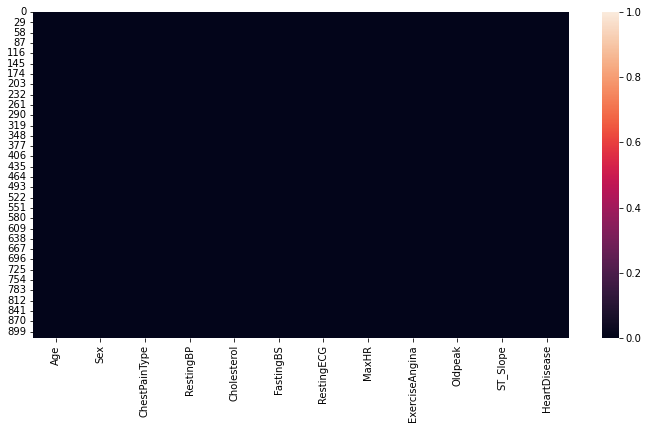

In [101]:
f, ax = plt.subplots(figsize=(12,6))
sns.heatmap(df.isna(),ax=ax,vmin=0,vmax=1)
plt.show()

Não existe nenhum valor nulo dentro do dataset. Por isso, podemos continuar com o trabalho.

### Vetorização

Para nosso trabalho será necessário, primeiro, executar a vetorização dos dados, ou seja, transformar cada observação em um vetor de valores que possa ser trabalho matematicamente.

In [102]:
## criando os pipelines para tratamento de valores categóricos e numéricos
cat_features = ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']
num_features = ['Age','RestingBP','Cholesterol','FastingBS','MaxHR','Oldpeak']

pipe_cat = make_pipeline(OneHotEncoder())
pipe_num = make_pipeline(Normalizer(),MinMaxScaler())

In [103]:
col_transformer = make_column_transformer(
    (pipe_cat,cat_features),
    (pipe_num,num_features))

col_transformer

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['Sex', 'ChestPainType', 'RestingECG',
                                  'ExerciseAngina', 'ST_Slope']),
                                ('pipeline-2',
                                 Pipeline(steps=[('normalizer', Normalizer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['Age', 'RestingBP', 'Cholesterol',
                                  'FastingBS', 'MaxHR', 'Oldpeak'])])

In [104]:
x = df[cat_features+num_features]
y = df.HeartDisease

In [105]:
x_vectorized = col_transformer.fit_transform(x)

### Removendo Outliers

In [106]:
iso = IsolationForest(random_state=42,n_estimators=300,contamination=0.09)
mask = pd.Series(iso.fit_predict(x_vectorized)).replace(-1,False).replace(1,True)

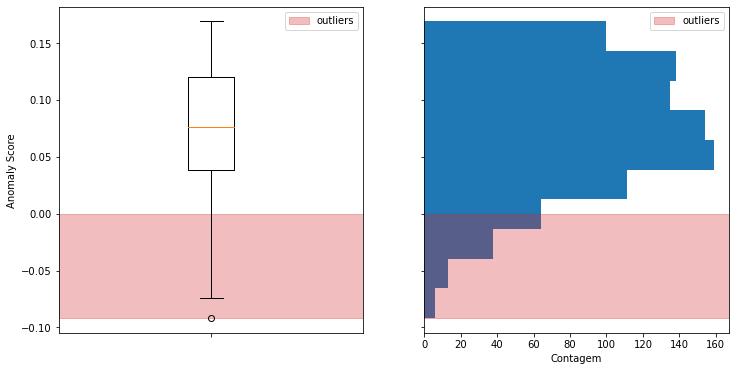

In [107]:
f, ax = plt.subplots(1,2,figsize=(12,6),sharey=True)

anon_score = iso.decision_function(x_vectorized)
ax[0].boxplot(anon_score)
ax[0].set_xticklabels([])
ax[0].set_ylabel('Anomaly Score')
ax[0].axhspan(anon_score.min(),0,alpha=0.3,color='tab:red',label='outliers')
ax[0].legend()

ax[1].hist(anon_score,orientation='horizontal')
ax[1].axhspan(anon_score.min(),0,alpha=0.3,color='tab:red',label='outliers')
ax[1].set_xlabel('Contagem')
ax[1].legend()

plt.show()

In [108]:
x_no_out = x[mask]
y_no_out = y[mask]

## Modelagem

### DecisionTree

Vamos criar um pipeline final contendo o objeto de pré-processamento e o modelo.

In [109]:
pipe_final = make_pipeline(col_transformer,tree.DecisionTreeClassifier(random_state=42))
pipe_final

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('normalizer',
                                                                   Normalizer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'FastingBS',
                                                   'MaxHR', 'Oldpeak'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

Esse objeto pipe_final contém as etapas de pré-processamento e também o modelo. Essa arquitetura de pré-processamento e pipelines foram escolhidas para que também sejam otimizadas pelo algoritmo genético.

In [111]:
cross_val_log = cross_validate(pipe_final,
                               x_no_out,
                               y_no_out,
                               scoring='f1',
                               return_train_score=True,
                               cv=10,
                               return_estimator=True)

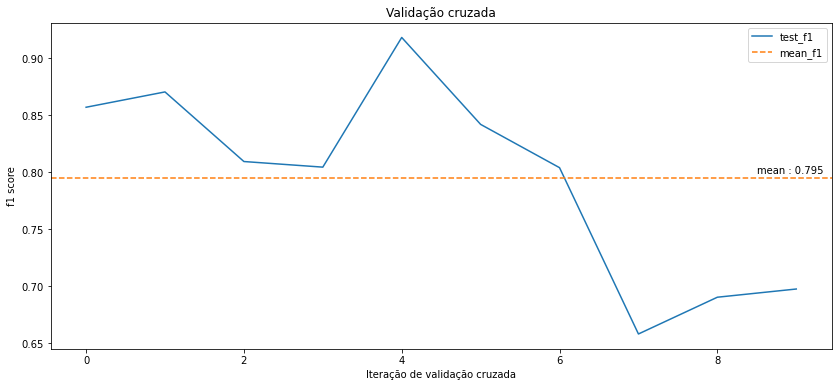

In [114]:
f ,ax = plt.subplots(figsize=(14,6))

ax.plot(cross_val_log['test_score'],label='test_f1')
ax.axhline(cross_val_log['test_score'].mean(),ls='--',label='mean_f1',color='tab:orange')
ax.text(x=8.5,y=cross_val_log['test_score'].mean()*1.005,s=f"mean : {round(cross_val_log['test_score'].mean(),3)}")
ax.set_xlabel('Iteração de validação cruzada')
ax.set_ylabel('f1 score')
ax.set_title('Validação cruzada')

ax.legend()
plt.show()

Sem nenhum processo de otimização a *DecisionTreeClassifier()* o f1 médio da classe positiva é de 0.795.

### Algoritmo Genético

Utilizaremos a biblioteca [sklearn-genetic-opt](https://sklearn-genetic-opt.readthedocs.io/en/stable/tutorials/basic_usage.html). O primeiro passo é a definição dos espaços de escolha de cada um dos parâmetros.

In [115]:
## verificando todo os parâmetros do objeto pipe_final

pipe_final.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder())]),
                                    ['Sex', 'ChestPainType', 'RestingECG',
                                     'ExerciseAngina', 'ST_Slope']),
                                   ('pipeline-2',
                                    Pipeline(steps=[('normalizer', Normalizer()),
                                                    ('minmaxscaler',
                                                     MinMaxScaler())]),
                                    ['Age', 'RestingBP', 'Cholesterol',
                                     'FastingBS', 'MaxHR', 'Oldpeak'])])),
  ('decisiontreeclassifier', DecisionTreeClassifier(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('pipeline-1',
                                 

Para o processo de otimização vamos tentar alterar os parâmetros :

1. 'columntransformer__pipeline-2__normalizer__norm' -> ['l1','l2','max']
2. 'columntransformer__pipeline-2__minmaxscaler' -> [MinMaxScaler(),StandardScaler()]
3. 'decisiontreeclassifier__min_samples_leaf' -> range(10,50)
4. 'decisiontreeclassifier__max_depth' -> range(1,20)

Obs.: Percebam que o parâmetro 'columntransformer__pipeline-2__minmaxscaler' apesar de ter minmaxscaler no nome vamos alterá-lo para avaliarmos outras formas de pré-processamento das variáveis numéricas.

In [116]:
param_grid = {
    'columntransformer__pipeline-2__normalizer__norm':Categorical(['l1','l2','max']),
    'columntransformer__pipeline-2__minmaxscaler':Categorical([MinMaxScaler(),StandardScaler()]),
    'decisiontreeclassifier__min_samples_leaf':Integer(10,50),
    'decisiontreeclassifier__max_depth':Integer(1,20)
}

Os parâmetros acima serão alterados em cada indivíduo e geração e somente os melhores serão utilizados para criar a próxima geração.

In [123]:
callbacks = [ProgressBar(),DeltaThreshold(0.0001,generations=3)]

clf_evolution = GASearchCV(estimator=pipe_final,
                     cv=10,
                     generations=10,
                     scoring='f1',
                     param_grid=param_grid,
                     n_jobs=-1,
                     verbose=True,
                     refit=True)

clf_evolution

GASearchCV(cv=10,
           estimator=Pipeline(steps=[('columntransformer',
                                      ColumnTransformer(transformers=[('pipeline-1',
                                                                       Pipeline(steps=[('onehotencoder',
                                                                                        OneHotEncoder())]),
                                                                       ['Sex',
                                                                        'ChestPainType',
                                                                        'RestingECG',
                                                                        'ExerciseAngina',
                                                                        'ST_Slope']),
                                                                      ('pipeline-2',
                                                                       Pipeline(steps=[('normalizer',
                                                                                        Normalizer(norm='max')),
                                                                                       ('minmaxscaler',
                                                                                        StandardScaler())]),
                                                                       ['Age',
                                                                        'RestingBP'...
                       'columntransformer__pipeline-2__normalizer__norm': <sklearn_genetic.space.space.Categorical object at 0x0000012F0FF6BF40>,
                       'decisiontreeclassifier__max_depth': <sklearn_genetic.space.space.Integer object at 0x0000012F0FF6EC40>,
                       'decisiontreeclassifier__min_samples_leaf': <sklearn_genetic.space.space.Integer object at 0x0000012F0FF6BE50>},
           return_train_score=True, scoring='f1')

In [124]:
evolved_model = clf_evolution.fit(x,y,callbacks=callbacks)

  0%|          | 0/11 [00:00<?, ?it/s]

gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	10    	0.82656	0.00796266 	0.836824   	0.815855   
1  	18    	0.832648	0.00235025 	0.836824   	0.829703   
2  	18    	0.833184	0.00187984 	0.835304   	0.831317   
3  	19    	0.834856	0.00245149 	0.840699   	0.831317   
4  	17    	0.835381	0.00212942 	0.840699   	0.831317   
5  	16    	0.835304	0          	0.835304   	0.835304   
6  	18    	0.835304	0          	0.835304   	0.835304   
INFO: DeltaThreshold callback met its criteria
INFO: Stopping the algorithm


In [125]:
evolved_model.best_params_

{'columntransformer__pipeline-2__normalizer__norm': 'l2',
 'columntransformer__pipeline-2__minmaxscaler': MinMaxScaler(),
 'decisiontreeclassifier__min_samples_leaf': 22,
 'decisiontreeclassifier__max_depth': 19}

## Conclusão

A validação cruzada da modelagem sem otimização resultou em um f1 (de teste, classe positiva) de 0.79. Enquanto o mesmo modelo passando por um processo de otimização através de algoritmo genético consegue chegar em um f1 (de teste, classe positiva) de 0.83. O processo de otimização, com certeza, ajudou, porém é interessante efetuar teste me problemas mais complexos e outros tipos de de dados, o próximo passo é tentar com redes neurais!!